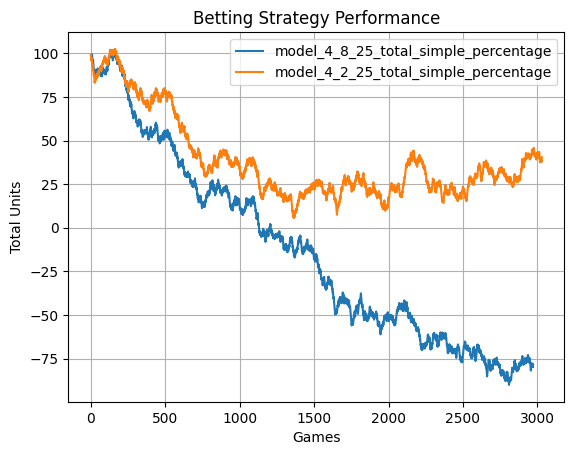

,Mean Average Error,Mean Squared Error,R-Squared,Sharpe,Net PNL,Max Drawdown,Winning Bet %
model,,,,,,,
model_4_8_25_total_simple_percentage,14.966688,342.701308,-0.047217,-0.241960,-178.22,-190.13,0.502692
model_4_2_25_total_simple_percentage,14.748660,337.143101,-0.041425,1.655939,-59.57,-94.40,0.524249


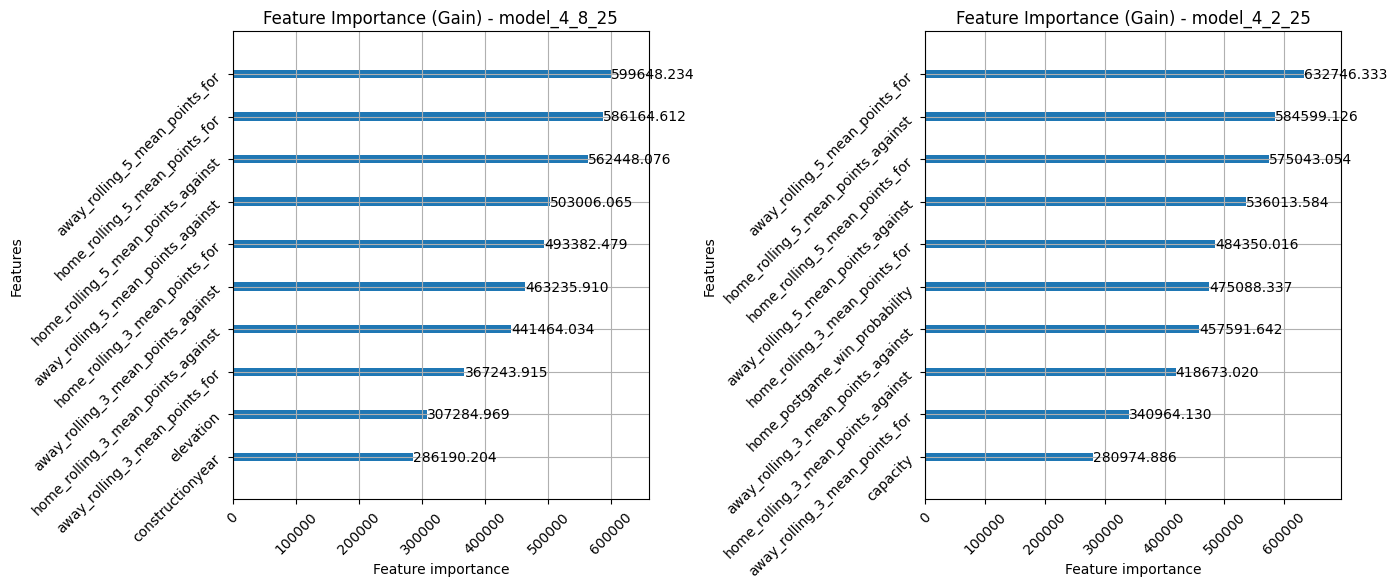

In [4]:
from evaluation import compare_models
compare_models("model_4_8_25", "model_4_2_25")

In [ ]:
from evaluation import load_pkl_if_exists
odds_df = load_pkl_if_exists("model_4_2_25")
odds_df[odds_df["unit_pnl"] == -1]

In [ ]:
print(odds_df["total"].std())
print(odds_df["pred"].std())

In [1]:
from data.data_prep import DataPrep
from db_utils import retrieve_data
from pipelines.preprocessing import preprocess_pipeline
from pipelines.pipeline import get_features_and_model_pipeline
import warnings
import pandas as pd

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)
pd.set_option('display.max_columns', None) 

print("Step 1: Loading data...")
data_prep = DataPrep(dataset="cfb")
raw_data = data_prep.get_data()

print("Step 2: Preprocess and separate odds, X, and y...")
preprocessed_data = preprocess_pipeline().fit_transform(raw_data)
target_col = "total"
betting_cols = ["min_ou", "max_ou"]

odds_df = preprocessed_data[[target_col] + betting_cols]
odds_df.loc[:, "pred"] = None
X = preprocessed_data.drop(columns=[target_col] + betting_cols)
y = preprocessed_data[target_col]

print("Step 3: Training and evaluating the model...")
pipeline = get_features_and_model_pipeline()

Step 1: Loading data...
Step 2: Preprocess and separate odds, X, and y...
Step 3: Training and evaluating the model...


In [3]:
pipeline.fit_transform(X)

,home_classification_fbs,home_classification_fcs,home_classification_ii,home_classification_iii,home_classification_None,away_classification_fbs,away_classification_fcs,away_classification_ii,away_classification_iii,away_classification_None,season_type_postseason,season_type_regular,season_type_spring_postseason,season_type_spring_regular,attendance,home_pregame_elo,away_pregame_elo,dome,grass,season,week,neutral_site,conference_game,home_postgame_elo,away_postgame_elo,capacity,elevation,constructionyear,home_days_since_last_game,away_days_since_last_game,home_rolling_3_mean_points_for,away_rolling_3_mean_points_for,home_rolling_5_mean_points_for,away_rolling_5_mean_points_for,home_rolling_3_mean_third_down_attempts,away_rolling_3_mean_third_down_attempts,home_rolling_3_mean_third_down_successes,away_rolling_3_mean_third_down_successes,home_rolling_3_mean_fourth_down_attempts,away_rolling_3_mean_fourth_down_attempts,home_rolling_3_mean_fourth_down_successes,away_rolling_3_mean_fourth_down_successes,home_rolling_3_mean_points_against,away_rolling_3_mean_points_against,home_rolling_5_mean_points_against,away_rolling_5_mean_points_against
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
332412309,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,20790.000000,1530.000000,1467.000000,False,False,2013,1,False,False,1536.0,1461.0,25319.0,321.364166,1969.0,4989,4989,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
332412579,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,81572.000000,1759.000000,1638.000000,False,True,2013,1,False,False,1785.0,1612.0,80250.0,60.545486,1934.0,4989,4989,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
332410154,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,26202.000000,1489.742857,1486.563358,False,False,2013,1,False,False,NaN,NaN,31500.0,283.548584,1968.0,4989,4989,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
332412710,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39107.029763,1518.840927,1486.563358,False,False,2013,1,False,False,NaN,NaN,16368.0,192.875565,1950.0,4989,4989,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
332410084,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,40278.000000,1484.986301,1486.563358,False,False,2013,1,False,False,NaN,NaN,52656.0,231.650085,1960.0,4989,4989,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401741208,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,39107.029763,1518.840927,1486.563358,False,True,2024,1,True,False,NaN,NaN,22000.0,13.681284,2012.0,15,15,44.666667,35.666667,43.6,36.8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,24.333333,12.2,21.6
401680057,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,9519.625000,1518.840927,1486.563358,False,True,2024,1,True,False,NaN,NaN,20500.0,181.381592,2005.0,16,16,44.000000,36.666667,39.2,39.4,0.000000,12.666667,0.000000,5.666667,0.000000,0.666667,0.000000,0.666667,17.666667,19.666667,18.4,21.8
401677189,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,50997.634146,2063.000000,2173.000000,False,False,2024,1,True,False,2067.0,2169.0,64767.0,2.624486,1987.0,9,7,35.333333,33.000000,35.2,36.6,13.000000,12.000000,6.000000,4.666667,1.333333,1.333333,0.666667,1.000000,23.000000,20.666667,20.2,18.0


In [ ]:

import pandas as pd


In [2]:
dp = DataPrep("cfb")
dat = dp.get_data()
game_team_stat_df = retrieve_data("cfb", "game_team_stats")

In [5]:
dat["away_third_down_eff"]

0         2-10
1         7-20
2         2-11
3          NaN
4         3-16
         ...  
25751      NaN
25752     8-12
25753    11-17
25754     3-10
25755     9-12
Name: away_third_down_eff, Length: 25756, dtype: object

In [ ]:
dat["passing_attempts"]

0        189.0
1        194.0
2         49.0
3          NaN
4        175.0
         ...  
25751      NaN
25752    200.0
25753    267.0
25754    289.0
25755    231.0
Name: away_net_passing_yards, Length: 25756, dtype: float64